In [124]:
import os
import re as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [116]:
y_min, y_max = 1403, 1914
x_min, x_max = 66, 577

geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][y_min:y_max+1, x_min:x_max+1]
lats = geodata["lat"][y_min:y_max+1, x_min:x_max+1]

# FSS

In [2]:
fss_path = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/fss/ncast"
out_dir = f"{fss_path}/plots"
os.makedirs(out_dir, exist_ok=True)
lead_times = [1, 3, 6]

In [3]:
files = [f for f in os.listdir(fss_path) if f.endswith(".csv")]
pattern = r"fss_hour_(\d{2})_t(\d)\.csv"

In [7]:
all_dfs = []
for fname in files:
    m = re.match(pattern, fname)
    if not m:
        continue
    hour = int(m.group(1))
    lt = int(m.group(2))
    df = pd.read_csv(os.path.join(fss_path, fname))
    df["hour"] = hour
    df["lead_time"] = lt

    # round scale to nearest 10 km
    if "scale_km" in df.columns:
        df["scale_km"] = (df["scale_km"] / 10).round() * 10

    all_dfs.append(df)

if not all_dfs:
    raise RuntimeError("No Fraction Skill Score CSV files found. Check path or pattern.")

fss_all = pd.concat(all_dfs, ignore_index=True)


fss_all["hour_bin"] = (fss_all["hour"] // 3) * 3
palette = plt.colormaps.get_cmap("tab10")

In [12]:
for lt in lead_times:
    df_lt = fss_all[fss_all["lead_time"] == lt]
    if df_lt.empty:
        print(f"No data for lead time t{lt}")
        continue

    # average within 3-hour bins
    df_mean = (
        df_lt.groupby(["hour_bin", "scale_km"], as_index=False)[["model", "persistence"]]
        .mean()
        .sort_values("hour_bin")
    )

    scales = sorted(df_mean["scale_km"].unique())
    n_scales = len(scales)
    colours = {s: palette(i / max(1, n_scales - 1)) for i, s in enumerate(scales)}

    plt.figure(figsize=(10, 6))

    for s in scales:
        df_s = df_mean[df_mean["scale_km"] == s]
        colour = colours[s]

        # Persistence: solid line, circle marker
        plt.plot(
            df_s["hour_bin"], df_s["persistence"],
            color=colour, linestyle="-", marker="o",
            markersize=6, linewidth=2.2
        )

        # Model: dashed line, triangle marker
        plt.plot(
            df_s["hour_bin"], df_s["model"],
            color=colour, linestyle="--", marker="^",
            markersize=5, linewidth=1.8
        )

    # reference line
    plt.axhline(y=0.5, color="grey", linestyle="--", linewidth=1, alpha=0.8)

    # axes and grid
    plt.xlabel("Hour of day (UTC, 3-hour bins)")
    plt.ylabel("Fractions Skill Score (FSS)")
    plt.xticks(range(0, 24, 3))
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3, linewidth=0.8)

    # legends
    scale_handles = [
        Line2D([], [], color=colours[s], marker="s", linestyle="", 
               markersize=6, label=f"{int(s)} km")
        for s in scales
    ]

    model_handles = [
        Line2D([], [], color="black", linestyle="-", marker="o",
               label="Persistence (solid, ●)"),
        Line2D([], [], color="black", linestyle="--", marker="^",
               label="Model (dashed, ▲)")
    ]

    first_leg = plt.legend(
        handles=scale_handles, title="Scale (km)",
        ncol=2, loc="upper right", fontsize=9
    )
    plt.gca().add_artist(first_leg)

    plt.legend(
        handles=model_handles, title="Method",
        loc="upper left", fontsize=9
    )

    plt.tight_layout()

    out_file = os.path.join(
        out_dir, f"fss_hour_model_vs_persistence_t{lt}_avg3h_tab10.png"
    )
    plt.savefig(out_file, dpi=300)
    plt.close()

    print(f"Saved: {out_file}")


Saved: /home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/fss/ncast/plots/fss_hour_model_vs_persistence_t1_avg3h_tab10.png
Saved: /home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/fss/ncast/plots/fss_hour_model_vs_persistence_t3_avg3h_tab10.png
Saved: /home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/fss/ncast/plots/fss_hour_model_vs_persistence_t6_avg3h_tab10.png


# AUC

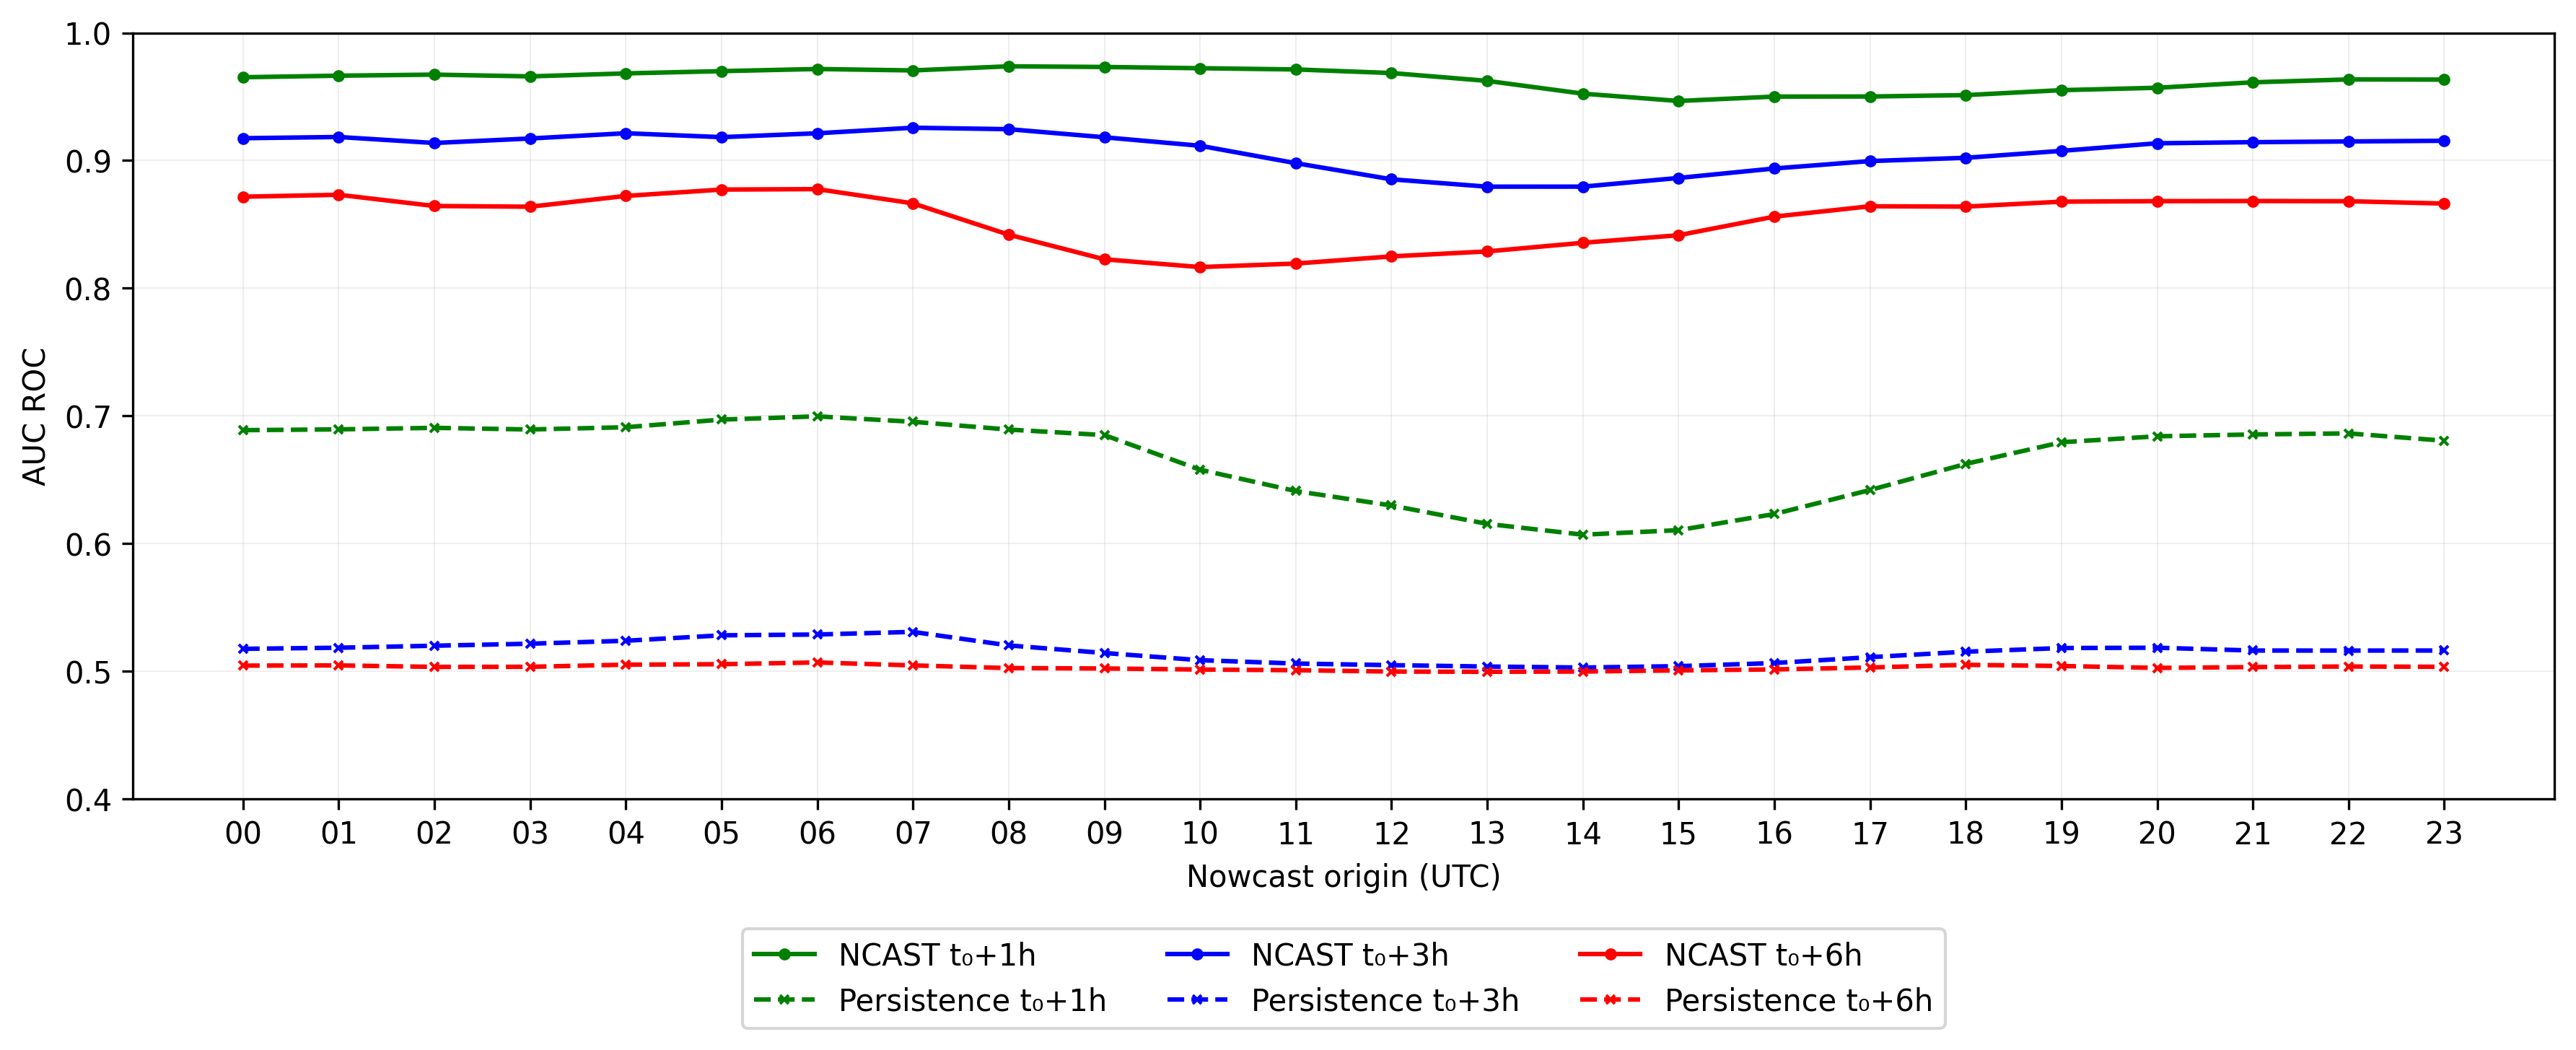

In [70]:
hours = [f"{h:02d}" for h in range(24)]
lead_times = ["1", "3", "6"]

auc_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/ncast/auc"

# colours to match previous plots
colours = {
    "1": "green",
    "3": "blue",
    "6": "red",
}

auc_model = {L: [] for L in lead_times}
auc_pers  = {L: [] for L in lead_times}

for L in lead_times:
    for h in hours:
        m_path = os.path.join(auc_dir, f"auc_model_hour_{h}_t{L}.npy")
        p_path = os.path.join(auc_dir, f"auc_persistence_hour_{h}_t{L}.npy")

        if os.path.exists(m_path):
            auc_model[L].append(float(np.load(m_path)))
            auc_pers[L].append(float(np.load(p_path)))
        else:
            auc_model[L].append(np.nan)
            auc_pers[L].append(np.nan)

plt.figure(figsize=(12,5), dpi=300)

for L in lead_times:
    c = colours[L]

    # model
    plt.plot(
        hours,
        auc_model[L],
        marker="o",
        markersize=3,
        linestyle="-",
        color=c,
        label=f"NCAST t₀+{L}h",
    )

    # persistence
    plt.plot(
        hours,
        auc_pers[L],
        marker="x",
        markersize=3,
        linestyle="--",
        color=c,
        label=f"Persistence t₀+{L}h",
    )

plt.xlabel("Nowcast origin (UTC)")
plt.ylabel("AUC ROC")
plt.ylim(0.4, 1)
plt.grid(True, linewidth=0.1)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3
)
plt.tight_layout()
plt.show()

In [36]:
bins = {
    "00-02": ["00", "01", "02"],
    "03-05": ["03", "04", "05"],
    "06-08": ["06", "07", "08"],
    "09-11": ["09", "10", "11"],
    "12-14": ["12", "13", "14"],
    "15-17": ["15", "16", "17"],
    "18-20": ["18", "19", "20"],
    "21-23": ["21", "22", "23"],
}

bin_labels = list(bins.keys())


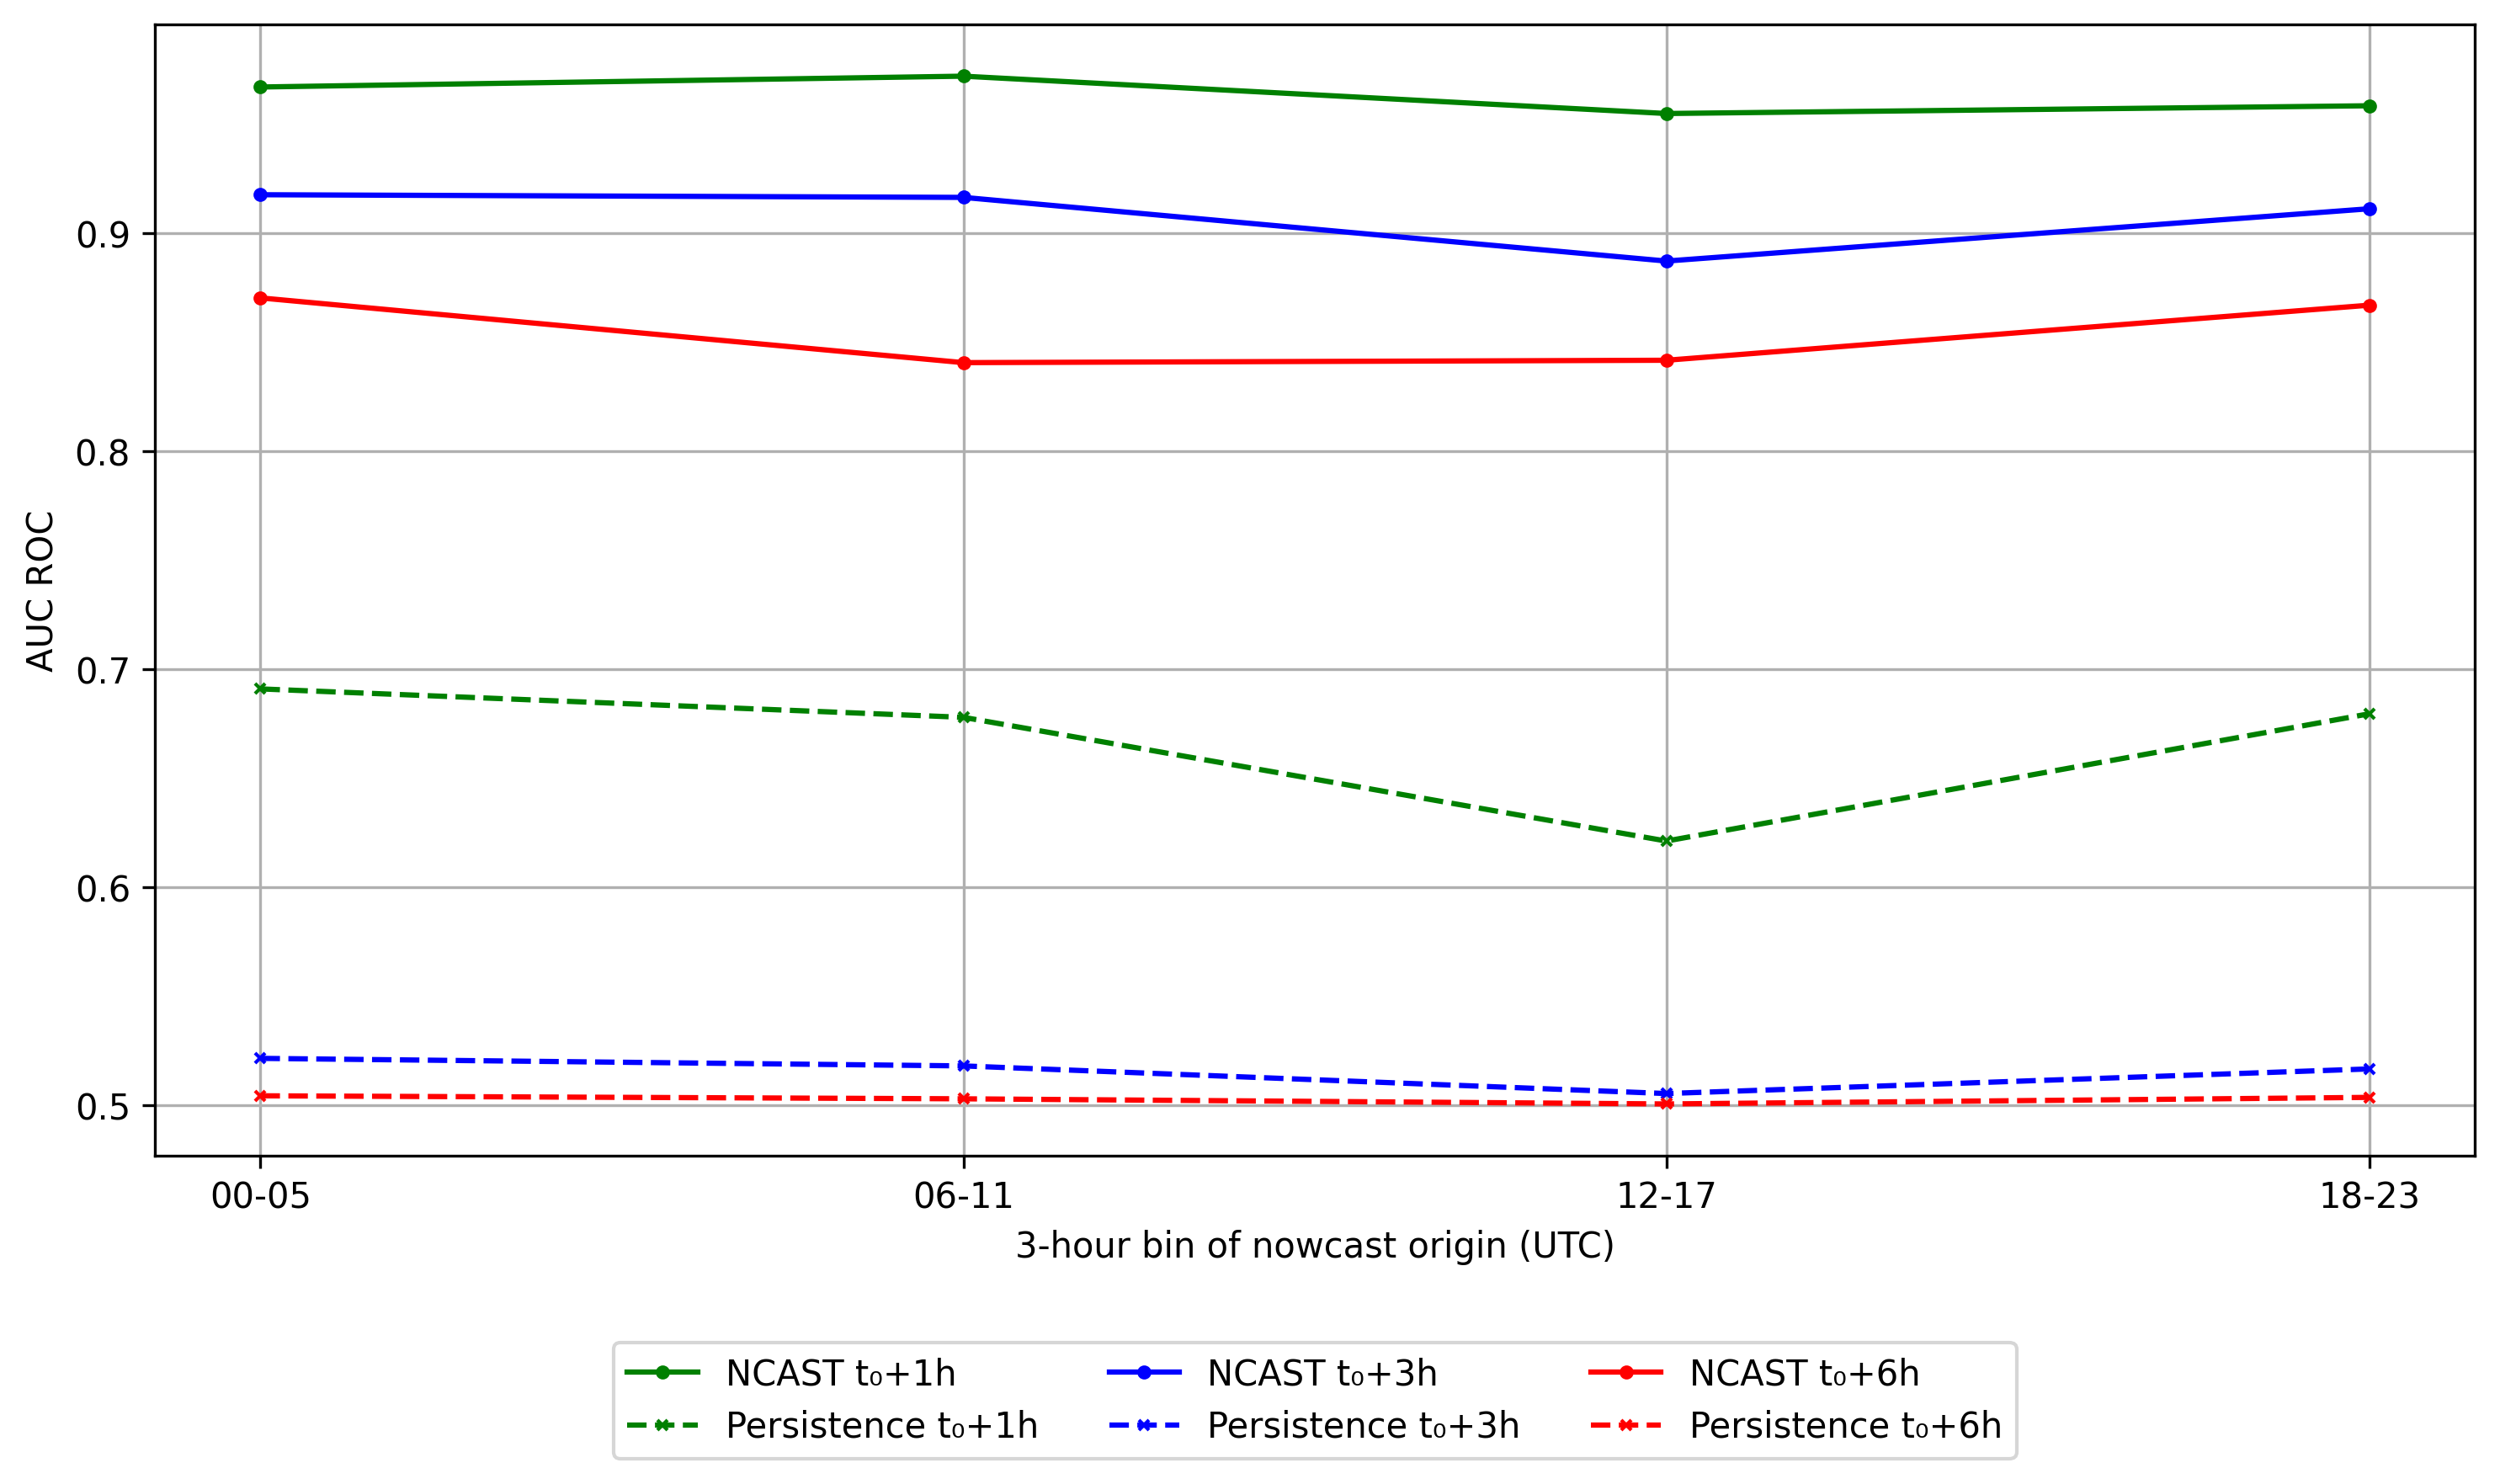

In [55]:
auc_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/ncast/auc"
lead_times = ["1", "3", "6"]

bin_labels = list(bins.keys())
model_marker = "o"
pers_marker = "x"

def load_auc(hour, lead):
    m_path = os.path.join(auc_dir, f"auc_model_hour_{hour}_t{lead}.npy")
    p_path = os.path.join(auc_dir, f"auc_persistence_hour_{hour}_t{lead}.npy")
    if os.path.exists(m_path) and os.path.exists(p_path):
        return float(np.load(m_path)), float(np.load(p_path))
    return np.nan, np.nan

auc_model_binned = {L: [] for L in lead_times}
auc_pers_binned = {L: [] for L in lead_times}

for L in lead_times:
    for label in bin_labels:
        hours = bins[label]
        vals_m = []
        vals_p = []
        for h in hours:
            am, ap = load_auc(h, L)
            vals_m.append(am)
            vals_p.append(ap)

        auc_model_binned[L].append(np.nanmean(vals_m))
        auc_pers_binned[L].append(np.nanmean(vals_p))

plt.figure(figsize=(10,6), dpi=300)

# colours for lead times
colours = {
    "1": "green",
    "3": "blue",
    "6": "red",
}

for L in lead_times:
    c = colours[L]
    label_suffix = f"t₀+{L}h"   # UTF-8 subscript zero

    # model
    plt.plot(
        bin_labels,
        auc_model_binned[L],
        linestyle="-",
        color=c,
        marker=model_marker,
        markersize=3,
        label=f"NCAST {label_suffix}",
    )

    # persistence
    plt.plot(
        bin_labels,
        auc_pers_binned[L],
        linestyle="--",
        color=c,
        marker=pers_marker,
        markersize=3,
        label=f"Persistence {label_suffix}",
    )

plt.xlabel("3-hour bin of nowcast origin (UTC)")
plt.ylabel("AUC ROC")
plt.grid(True)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3
)

plt.tight_layout()
plt.show()

# BSS

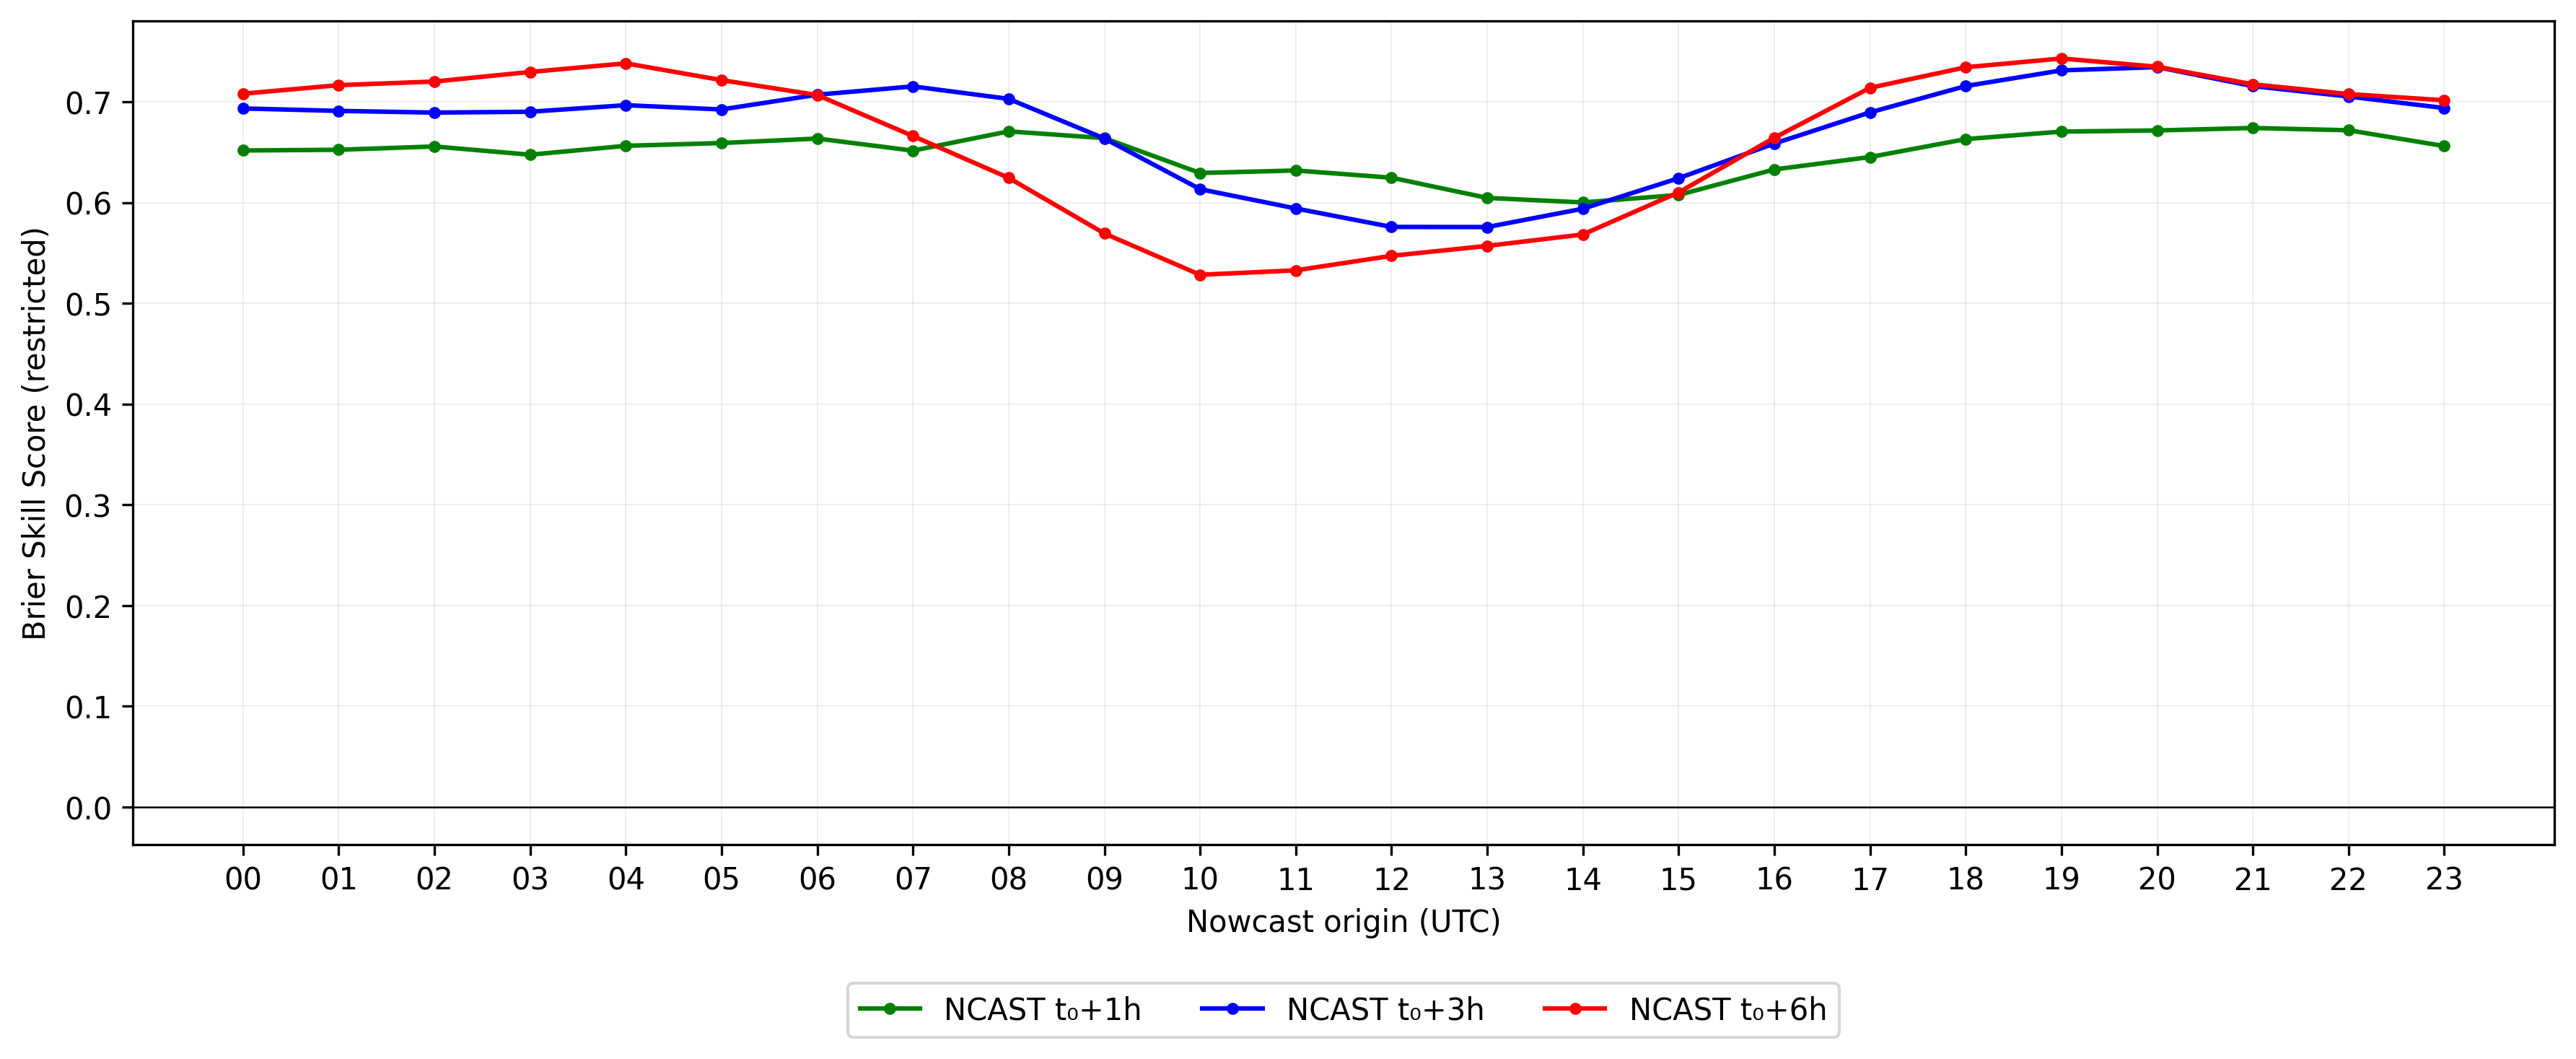

In [110]:
hours = [f"{h:02d}" for h in range(24)]
lead_times = ["1", "3", "6"]

bss_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/ncast/bss/improved"

# matching your colour scheme
colours = {
    "1": "green",
    "3": "blue",
    "6": "red",
}

bss_model = {L: [] for L in lead_times}

# load BSS values
for L in lead_times:
    for h in hours:
        m_path = os.path.join(bss_dir, f"bss_model_hour_{h}_t{L}.npy")

        if os.path.exists(m_path):
            bss_model[L].append(float(np.load(m_path)))
        else:
            bss_model[L].append(np.nan)

# plotting
plt.figure(figsize=(12,5), dpi=300)

for L in lead_times:
    c = colours[L]

    plt.plot(
        hours,
        bss_model[L],
        marker="o",
        markersize=3,
        linestyle="-",
        color=c,
        label=f"NCAST t₀+{L}h",
    )

plt.xlabel("Nowcast origin (UTC)")
plt.ylabel("Brier Skill Score (restricted)")
plt.grid(True, linewidth=0.1)

# baseline = persistence
plt.axhline(0, color="black", linewidth=0.6)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_3105988/67747190.py:15: RuntimeWarning: Mean of empty slice
  bss_bin_maps[label] = np.nanmean(np.stack(maps), axis=0)


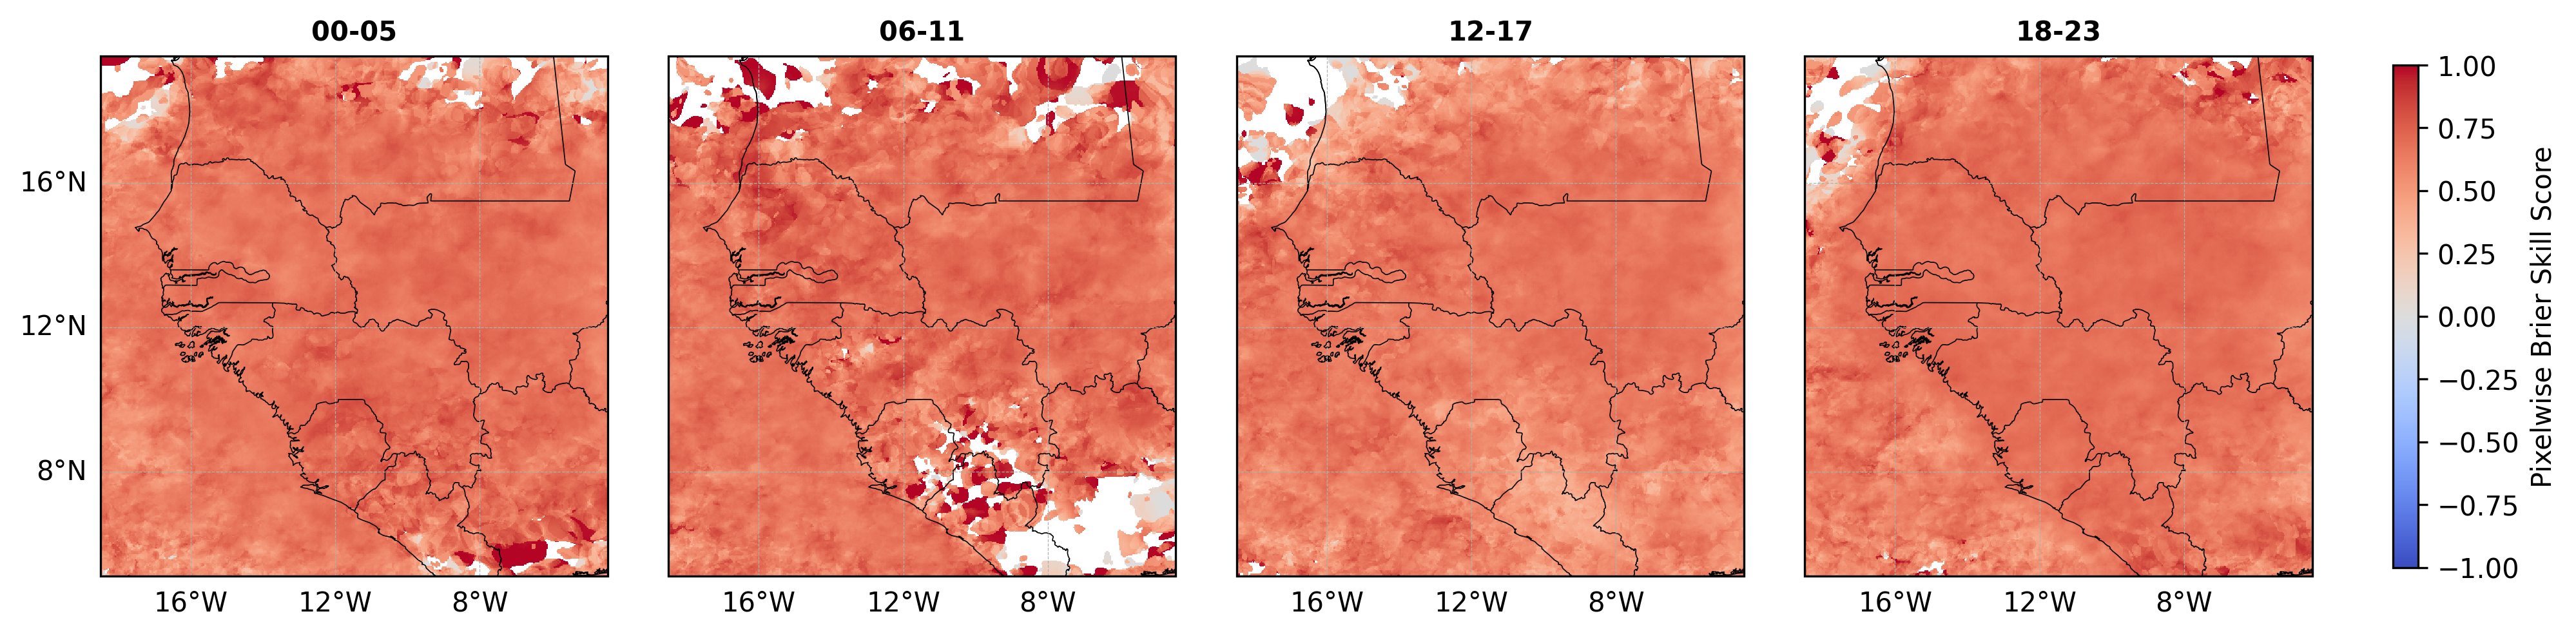

In [126]:
lead_time = "1"  # change as needed

def load_bss(hour, lead):
    path = os.path.join(bss_dir, f"pixelwise_bss_hour_{hour}_t{lead}.npy")
    if os.path.exists(path):
        return np.load(path)
    return None

# compute bin means
bss_bin_maps = {}
for label, hours in bins.items():
    maps = [load_bss(h, lead_time) for h in hours]
    maps = [m for m in maps if m is not None]
    if maps:
        bss_bin_maps[label] = np.nanmean(np.stack(maps), axis=0)
    else:
        bss_bin_maps[label] = None

# longitudes & latitudes for the grid (matching your 512x512 Africa domain)
lat_min, lat_max = 5.1, 19.5
lon_min, lon_max = -18.5, -4.45

lats = np.linspace(lat_min, lat_max, 512)
lons = np.linspace(lon_min, lon_max, 512)

# grid for pcolormesh
lon_grid, lat_grid = np.meshgrid(lons, lats)

# cartopy setup
fig, axes = plt.subplots(
    1, 4,
    figsize=(18, 4.5),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

plt.subplots_adjust(wspace=0.12)

# symmetric colour scale
vmax = 1.0
vmin = -1.0
cmap = "coolwarm"

x_ticks = np.arange(-20, 0, 4)
y_ticks = np.arange(4, 22, 4)

shapename = "admin_0_countries"
countries_shp = shpreader.natural_earth("10m", "cultural", shapename)

for i, (label, hours) in enumerate(bins.items()):
    bss_map = bss_bin_maps[label]

    ax = axes[i]
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="none", linewidth=0.4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.4)

    if bss_map is not None:
        masked = np.ma.masked_invalid(bss_map)
        im = ax.pcolormesh(
            lon_grid, lat_grid, masked,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            shading="auto",
            vmin=vmin,
            vmax=vmax
        )
    else:
        im = None

    gl = ax.gridlines(draw_labels=True, alpha=1, linestyle="--", linewidth=0.3)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = (i == 0)
    gl.xlocator = mticker.FixedLocator(x_ticks)
    gl.ylocator = mticker.FixedLocator(y_ticks)

    ax.set_title(f"{label}", fontsize=10, fontweight="bold")

# colourbar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(),
    shrink=0.75, pad=0.03,
    label="Pixelwise Brier Skill Score"
)

plt.show()


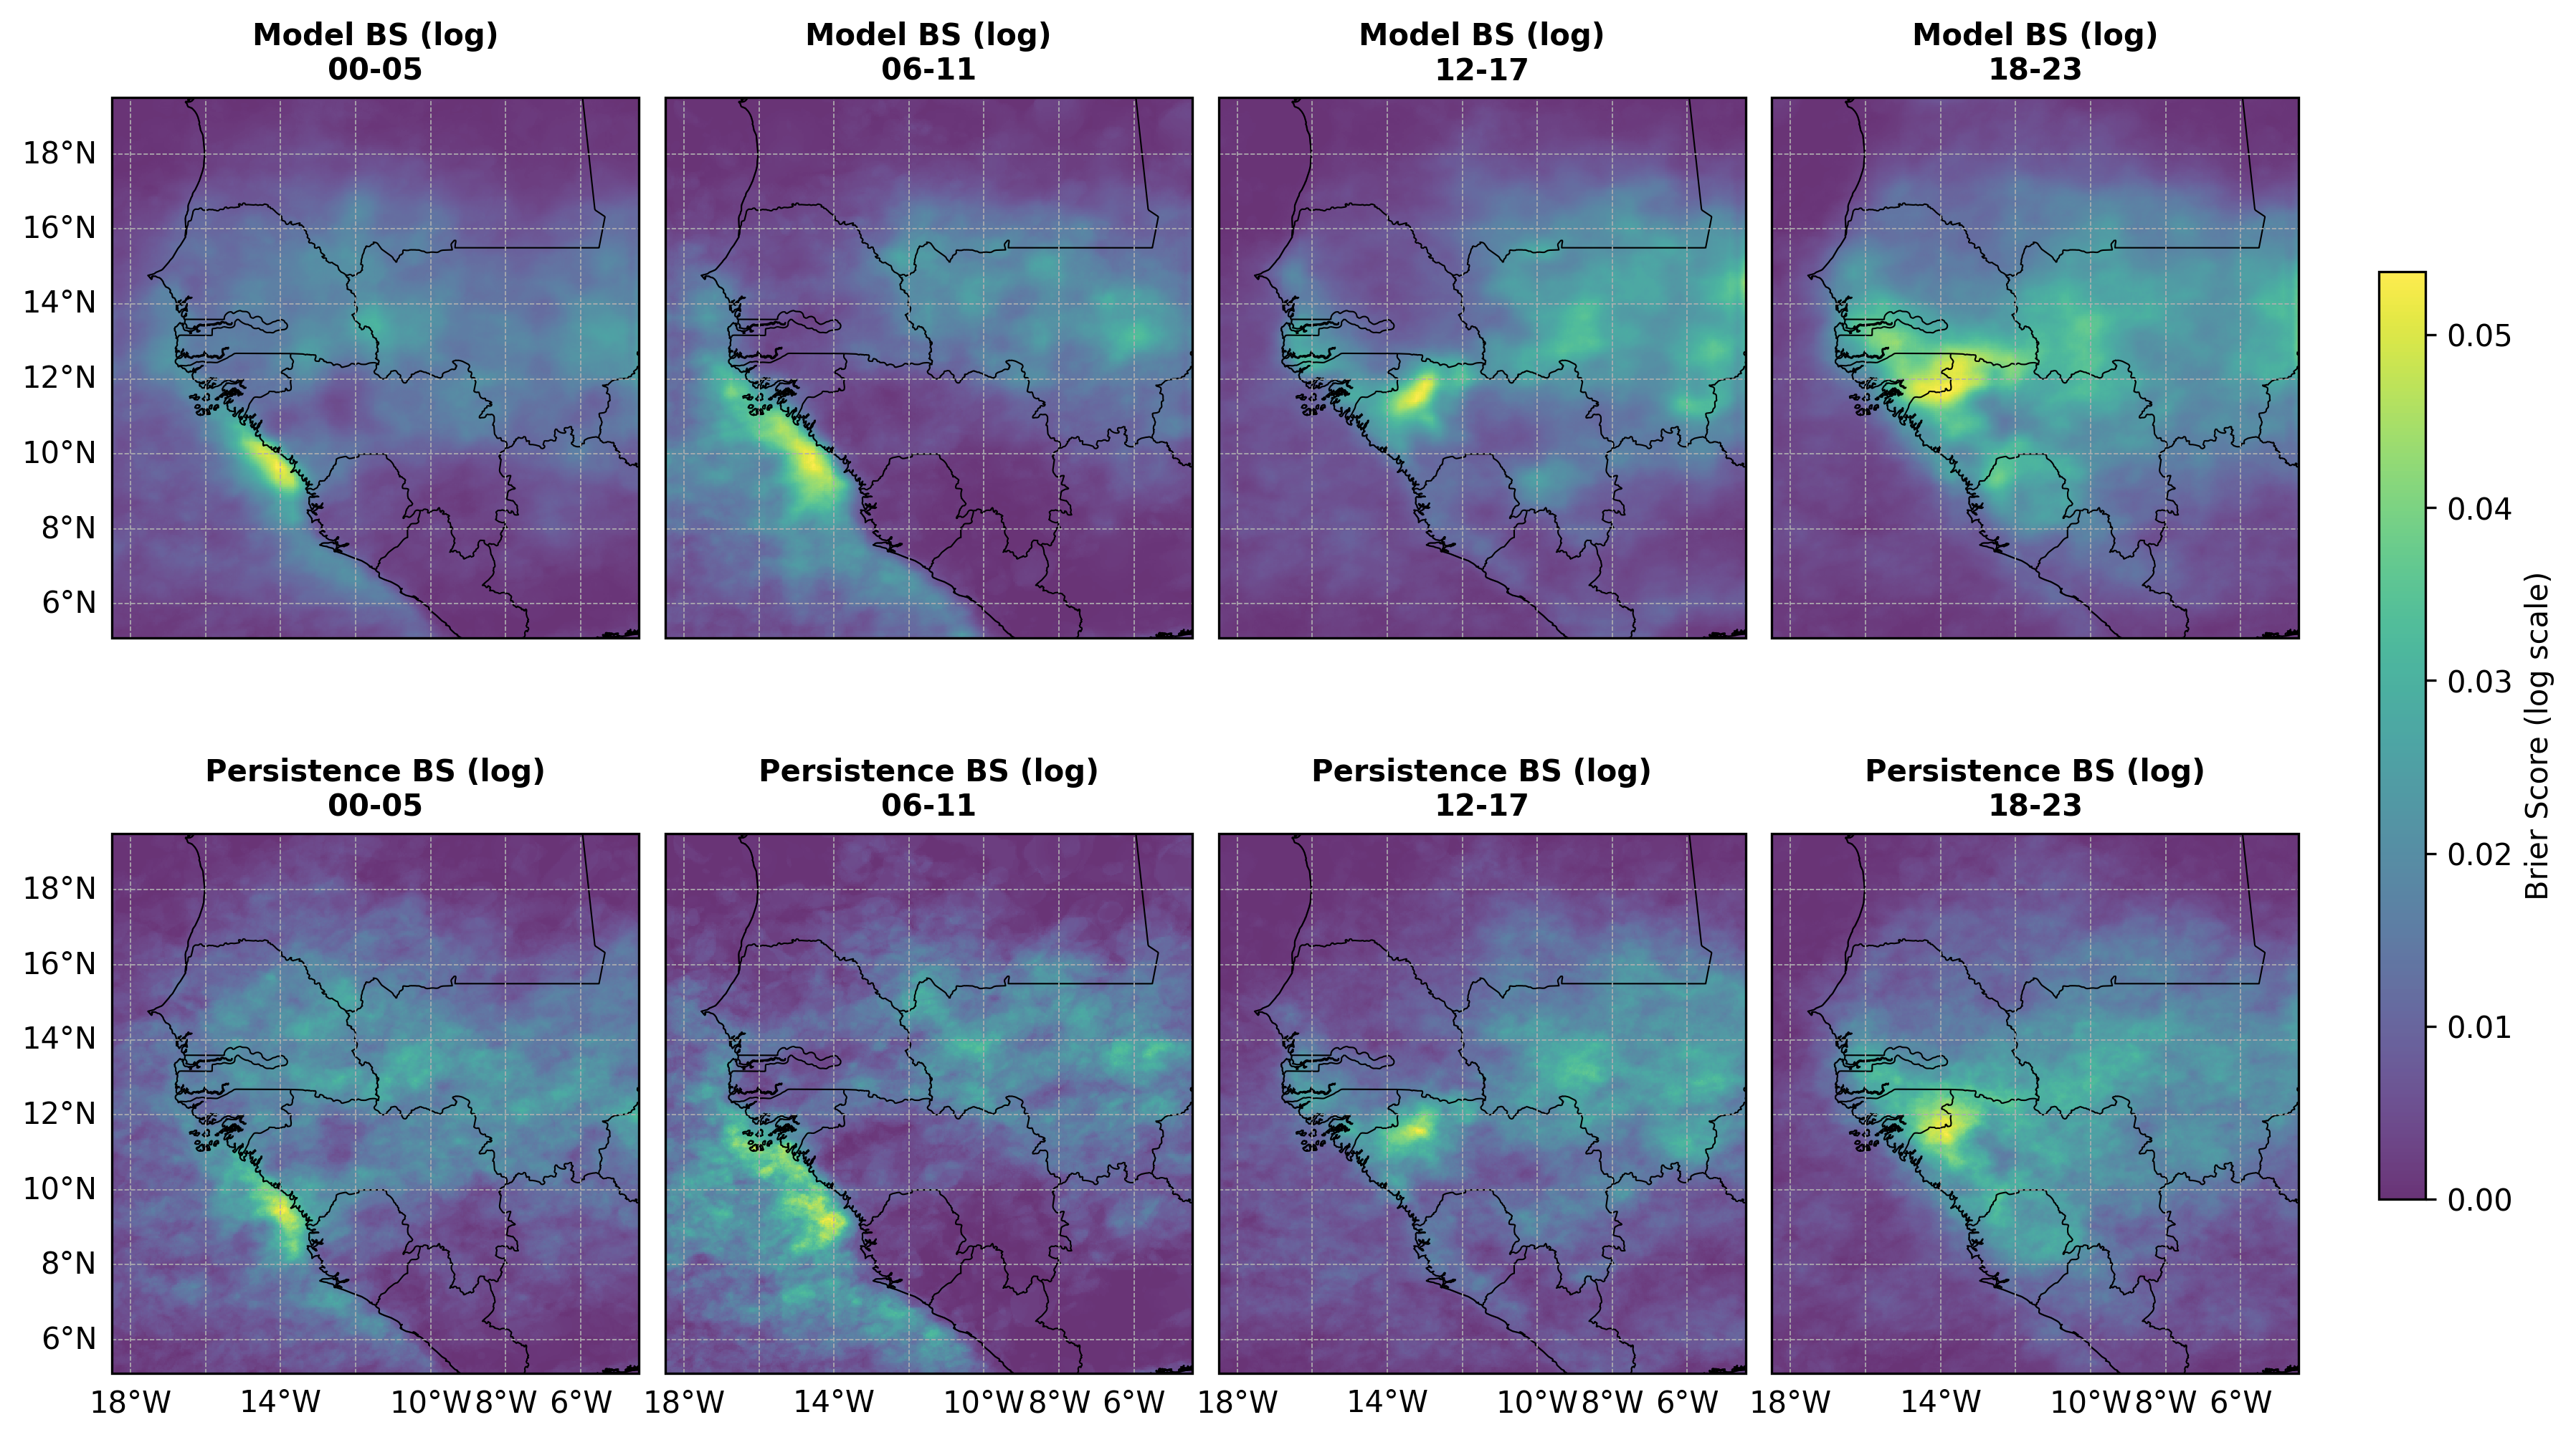

In [128]:
bs_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/ncast/bs"
lead_time = "1"

def load_bs_model(hour, lead):
    path = os.path.join(bs_dir, f"bs_model_hour_{hour}_t{lead}.npy")
    if os.path.exists(path):
        return np.load(path)
    return None

def load_bs_persist(hour, lead):
    path = os.path.join(bs_dir, f"bs_persist_hour_{hour}_t{lead}.npy")
    if os.path.exists(path):
        return np.load(path)
    return None

# compute means per bin
model_maps = {}
pers_maps = {}

for label, hours in bins.items():
    m_arrs, p_arrs = [], []
    for h in hours:
        m = load_bs_model(h, lead_time)
        p = load_bs_persist(h, lead_time)
        if m is not None:
            m_arrs.append(m)
        if p is not None:
            p_arrs.append(p)

    model_maps[label] = np.nanmean(np.stack(m_arrs), axis=0) if m_arrs else None
    pers_maps[label] = np.nanmean(np.stack(p_arrs), axis=0) if p_arrs else None

groups = [(label, model_maps[label], pers_maps[label])
          for label in bins.keys()
          if model_maps[label] is not None and pers_maps[label] is not None]

if not groups:
    raise RuntimeError("No valid BS maps found.")

lat_min, lat_max = 5.1, 19.5
lon_min, lon_max = -18.5, -4.45

n_groups = len(groups)
fig, axes = plt.subplots(
    2, n_groups,
    figsize=(4 * n_groups, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

plt.subplots_adjust(hspace=0.25, wspace=0.05)

vmin, vmax = 1e-6, 1

shapename = "admin_0_countries"
countries_shp = shpreader.natural_earth(resolution="10m",
                                        category="cultural", name=shapename)
africa_geoms = [rec.geometry for rec in shpreader.Reader(countries_shp).records()]

x_ticks = np.arange(-20, 0, 2)
y_ticks = np.arange(4, 22, 2)

for i, (label, bs_m, bs_p) in enumerate(groups):
    for row, bs_map in enumerate([bs_m, bs_p]):
        ax = axes[row, i]
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black", linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor="none")
        ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

        im = ax.pcolormesh(
            lons, lats, bs_map,
            transform=ccrs.PlateCarree(),
            cmap="viridis",
            shading="auto",
            alpha=0.8
        )

        gl = ax.gridlines(draw_labels=True, alpha=1, linestyle="--", linewidth=0.4)
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = (row == 1)
        gl.left_labels = (i == 0)
        gl.xlocator = mticker.FixedLocator(x_ticks)
        gl.ylocator = mticker.FixedLocator(y_ticks)

        if row == 0:
            ax.set_title(f"Model BS (log)\n{label}", fontsize=10, fontweight="bold")
        else:
            ax.set_title(f"Persistence BS (log)\n{label}", fontsize=10, fontweight="bold")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    shrink=0.7, pad=0.03,
                    label="Brier Score (log scale)")

plt.show()
